##### Import necessary libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings("ignore")

### 1) Data Reading

- Data Source --> https://www.kaggle.com/datasets/rakeshrau/social-network-ads

In [3]:
df = pd.read_csv("data/Social_Network_Ads.csv")
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


- No null values inspected

In [5]:
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


### 2) Data Visualization

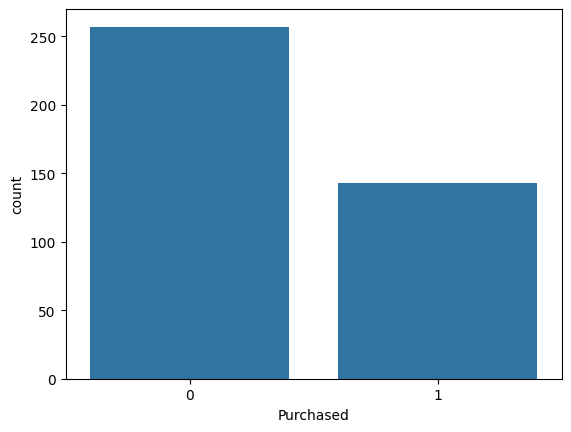

In [ ]:
# Check the label distributions (Future Use: SMOTE can be used to balance the labels)
fig = sns.countplot(data=df, x="Purchased")

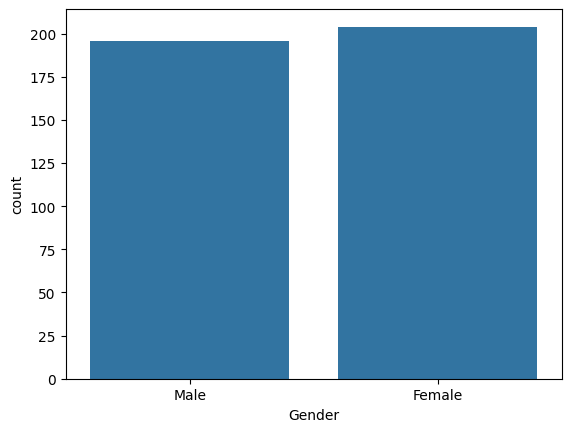

In [7]:
# Gender distributions
fig = sns.countplot(data=df, x="Gender")

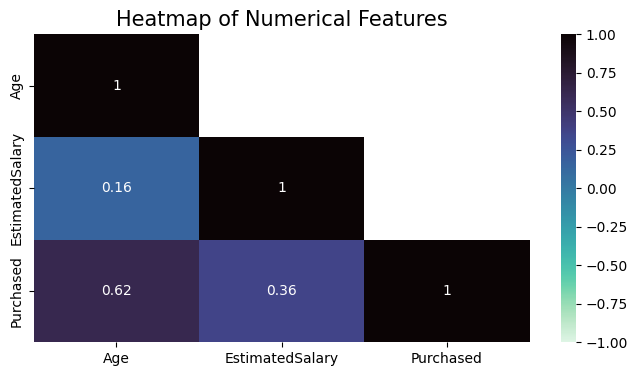

In [17]:
# Heatmap - Numerical features and Target distributions
plt.figure(figsize=(8,4))

corr = df.drop(columns=["User ID", "Gender"]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

np.fill_diagonal(mask, False) # Only display the lower diagonal as the upper diagonal is symmetric of it

sns.heatmap(corr, annot=True, mask=mask, 
    vmin=-1, vmax=1, cmap='mako_r'
    )

plt.grid(False)
plt.title("Heatmap of Numerical Features", fontsize=15)
plt.show()

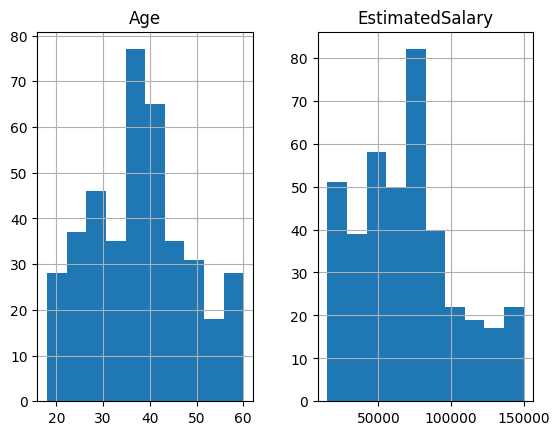

In [18]:
# Numerical features distributions
fig = df[["Age", "EstimatedSalary"]].hist()

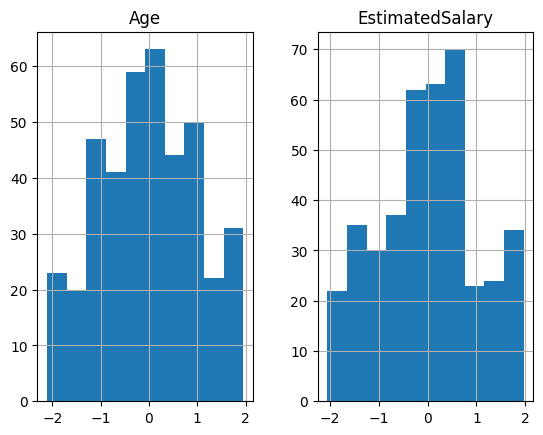

In [19]:
# Visually inspect the PowerTransformer effect on the numerical inputs
df_ = df.copy(deep=True)

# We can use box-cox transformation for the normalization since both Age and EstimatedSalary features have strcitly positive values
scaler = PowerTransformer(method="box-cox")

df_["Age"] = scaler.fit_transform(df_["Age"].values.reshape(-1,1))
df_["EstimatedSalary"] = scaler.fit_transform(df_["EstimatedSalary"].values.reshape(-1,1))

fig = df_[["Age", "EstimatedSalary"]].hist()

### 3) Preprocessing - Hyperparameter Tuning and Baseline Classification

In [21]:
numeric_features = ['Age', 'EstimatedSalary']
categorical_features = ['Gender']

X = df.drop(columns=["User ID", "Purchased"])
y = df["Purchased"]

# Split the dataset as train and test
X_train_, X_test, y_train_, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Split train dataset to train and validation for fine-tuning the classifier
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.33, random_state=42)

In [22]:
# Preprocess training dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(method="box-cox"), numeric_features),
        ('cat',  OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [23]:
# Full pipeline with a baseline classifier
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

baseline_pipeline.fit(X_train_, y_train_)

y_pred = baseline_pipeline.predict(X_test)
print("Accuracy Score -->", round(accuracy_score(y_test, y_pred),2))

y_pred_proba = baseline_pipeline.predict_proba(X_test)
print("Log Loss -->", round(log_loss(y_test, y_pred_proba),2))

Accuracy Score --> 0.86
Log Loss --> 4.92


### Hyperparameter Tuning For XGBoost Classifier

- Use XGBoost Classifier as the main predictor and randomized grid search for faster parameter tuning
- Tune parameters for optimizing binary-crossentropy (log-loss)
- Future Use: Apply early stopping method to optimize loss

In [ ]:
# Use XGBoost's native wrapper
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Full pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Define hyperparameter search space
param_grid = {
    'classifier__n_estimators': [100, 200],              # # of boosting rounds
    'classifier__max_depth': [3, 5, 7],                  # max depth of trees
    'classifier__learning_rate': [0.01, 0.05, 0.1],      # shrinkage
    'classifier__subsample': [0.7, 0.9, 1.0],            # % of training data per boosting round
    'classifier__colsample_bytree': [0.7, 0.9, 1.0],     # % of features per tree
    'classifier__gamma': [0, 1, 5],                      # min loss reduction (regularization)
    'classifier__reg_alpha': [0, 0.1, 1],                # L1 regularization
    'classifier__reg_lambda': [1, 5, 10]                 # L2 regularization
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch with neg_log_loss
randomized_grid_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid,
    scoring='neg_log_loss',
    n_iter=1000,
    cv=cv,
    verbose=1
)

# Fit the search grid
randomized_grid_search.fit(X_train_, y_train_)

# Results
print("Best Params:", randomized_grid_search.best_params_)
print(f"Best CV Log Loss: {-randomized_grid_search.best_score_:.4f}")

# Test set performance
y_pred = randomized_grid_search.predict(X_test)
print("Accuracy Score -->", round(accuracy_score(y_test, y_pred),2))

y_pred_proba = randomized_grid_search.predict_proba(X_test)
print("Log Loss -->", round(log_loss(y_test, y_pred_proba),2))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best Params: {'classifier__subsample': 1.0, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__gamma': 1, 'classifier__colsample_bytree': 1.0}
Best CV Log Loss: 0.2871
Accuracy Score --> 0.95
Log Loss --> 0.2


### 4) Final Model Training - Results and Saving

In [ ]:
# Use the wrapped model with the best parameters
xgb_model = XGBClassifier(
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0,
    reg_lambda=1,
    learning_rate=0.1,
    gamma=1,
    n_estimators=100,
    max_depth=3,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Final pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

xgb_pipeline.fit(X_train_, y_train_)

# Print test set performance
y_pred = xgb_pipeline.predict(X_test)
print("Accuracy Score -->", round(accuracy_score(y_test, y_pred),2))

y_pred_proba = xgb_pipeline.predict_proba(X_test)
print("Log Loss -->", round(log_loss(y_test, y_pred_proba),2))

Accuracy Score --> 0.95
Log Loss --> 0.2


In [26]:
# Save the trained model

if not os.path.exists("./model"):
    os.mkdir("./model")

with open("model/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_pipeline, f)
f.close()